# USD/MXN Exchange Rate during 2016 US Election Night - Under Construction

During the night of the 2016 US election night, we saw Donald Trump won the presidency while most polling agency predicted Hillary Clinton would be victorious. This came as a suprise to the most people. In this project I would like to how the financial market reacted during the election night.

## Background:
During the campaign Donald Trump repeatedly mentioned building a wall between the US and Mexico boarder, putting high import tariff on imported goods from Mexico and renegotiate or abandon NAFTA. All such action are seen as negatives for the Mexican economy whose biggest export market is the US. It is no suprise that in the event of a trump victory, the Mexican Peso will depreciate against other currencies.

In this project I will run a realtime analysis on Trumps victory chance and see how fast the financial market reacted as the result came out from each state.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug  2 16:32:27 2017

@author: AlexH
"""

#Priors 1: state, number


#Updates & Results: state, time, number

#Step 1, get all data (use just website time info for now)

#Step 2, rolling regression

#Step 3, find error margin at each stage

#Step 4, compare with financial data
    

import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import statsmodels.api as sm

import pandas as pd
from collections import OrderedDict
from datetime import date

from datetime import datetime
import matplotlib.dates as mdates
import pylab


C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Getting the Data

The data is collected from the internet, polling data is from Fivethrityeight 'prior-538.csv' and the election realtime data is recorded by watching BBC/CNN election live broadcast 'results.csv'.

In [40]:
#%%
#Reading in data


# with open('data/prior_538.csv', newline='') as csvfile:
#     data = csv.reader(csvfile, delimiter=',')
#     prior=list(data)
prior = pd.read_csv('data/prior_538.csv')

prior = pd.DataFrame(prior)
prior.columns = ['State', 'poll_hc', 'poll_dt', 'poll_gj']
prior.State=[name.replace('-',' ') for name in prior.State]

#with open('call-AP.csv', newline='') as csvfile:
#    data = csv.reader(csvfile, delimiter=',')
#    call=list(data)
#
#call = pd.DataFrame(call)
#call.columns = ['State', 'result', 'time']

with open('data/results CNN.csv', newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    result=list(data)

result = pd.DataFrame(result)
result.columns = ['State', 'result', 'time', 'trump', 'clinton', 'EV', 'intermediate','rprpc']
result.State=[name.lower() for name in result.State]


#join the table by state
jointb = prior.join(result.set_index('State'), on='State')
#order by time






jointb = jointb.sort_values(by='time').reset_index(drop=True)
jointb.index = np.arange(0,len(jointb))
jointb[[ 'EV','result', 'trump', 'clinton', 'poll_hc', 'poll_dt', 'poll_gj']]=jointb[[ 'EV','result', 'trump', 'clinton','poll_hc', 'poll_dt', 'poll_gj' ]].apply(pd.to_numeric)
#jointb.EV.fillna(0,inplace =True)


### Linear Regression and Monte Carlos Simulation



In [53]:

#storing result
columns = ['time', 'state','low', 'ave', 'high']
index= jointb.index
pred=pd.DataFrame(index=index, columns=columns)

#number of simulation for (a,b) and (error)
sim_num = 200
for i in range(14,len(jointb)-6):
    
    #Trump regression
    #fit linear regression
    select=jointb[0:i]
    full_result=select[select.intermediate!='1'].drop_duplicates(subset='State', keep='last')
    intermediate = select[select.intermediate=='1'].drop_duplicates(subset='State', keep='last')

    X_dt=intermediate['poll_dt']
    Y_dt=intermediate['trump']
    X_dt=sm.add_constant(X_dt)
    model_dt = sm.RLM(Y_dt.values, X_dt.values).fit()
    
    #extract parameters
    const_dt = np.random.normal(model_dt.params[0], model_dt.bse[0], sim_num)
    slope_dt = np.random.normal(model_dt.params[1], model_dt.bse[1], sim_num)
    
    #Clinton regression
    X_hc=intermediate['poll_hc']
    Y_hc=intermediate['clinton']
    X_hc=sm.add_constant(X_hc)
    model_hc = sm.RLM(Y_hc, X_hc).fit()
    
    #extract parameters
    const_hc = np.random.normal(model_hc.params[0], model_hc.bse[0], sim_num)
    slope_hc = np.random.normal(model_hc.params[1], model_hc.bse[1], sim_num)
    
    #make predictions, use states with no results and intermediate results
    remain=jointb[~jointb.State.isin(full_result.State)].drop_duplicates(subset='State', keep='last')
    
    result = np.zeros([sim_num, len(remain)])
    
    for j in range(0, len(const_dt)):
        
        #trump
        error_dt = np.random.normal(np.mean(model_dt.resid), np.std(model_dt.resid), sim_num)
        result_dt = np.array([v + const_dt[j] + slope_dt[j]*np.array(remain['poll_dt']) for v in error_dt])
        
        #clinton
        error_hc = np.random.normal(np.mean(model_hc.resid), np.std(model_hc.resid), sim_num)
        result_hc = np.array([v + const_hc[j] + slope_hc[j]*np.array(remain['poll_hc']) for v in error_hc])
        
        
        result_temp = result_dt>result_hc
        result = np.append(result, result_temp,axis=0)
       
    #remove the zeros during initialisation
    result = np.delete(result,range(0,sim_num),0)
    result = result.astype(int)
        
    #filling the result of intermediates states with current count
#    select.result[select.result.isnull()[0:i]]=(select['trump'][select.result.isnull()[0:i]]>=select['clinton'][select.result.isnull()[0:i]]).astype(int)
    
    EEV=sum(full_result['result'] * full_result['EV'])+ np.dot(result, remain['EV'])
#    print(jointb['time'][i],jointb['State'][i], EEV)

    #make table for plot
    pred.time[i]=datetime.strptime(jointb.time[i], '%Y-%m-%d %H:%M')
    pred.state[i]=jointb.State[i]
    pred.low[i]=np.mean(EEV)-np.std(EEV)
    pred.ave[i]=np.mean(EEV)
    pred.high[i]=np.mean(EEV)+np.std(EEV)
    print(pred.time[i])
    print(model_dt.params)

# keep only the last value at a certain time. And remove NAs.
pred=pred.drop_duplicates(subset='time', keep='last').dropna(axis=0, how='all')
pred.index = np.arange(0,len(pred))

2016-11-08 20:09:00
[ 402.75   -7.5 ]
2016-11-08 20:13:00
[ 402.75   -7.5 ]
2016-11-08 20:26:00
[ 402.75   -7.5 ]
2016-11-08 20:30:00
[ 402.75   -7.5 ]
2016-11-08 20:30:00
[ 402.75   -7.5 ]
2016-11-08 20:30:00
[ 641.25  -12.5 ]
2016-11-08 20:39:00
[ 760.5  -15. ]
2016-11-08 20:51:00
[ 760.5  -15. ]
2016-11-08 20:58:00
[ 760.5  -15. ]
2016-11-08 21:00:00
[ 760.5  -15. ]
2016-11-08 21:00:00
[ 760.5  -15. ]
2016-11-08 21:00:00
[ 93.27876947  -0.97440863]
2016-11-08 21:00:00
[ 93.27876947  -0.97440863]
2016-11-08 21:00:00
[ 93.27876947  -0.97440863]
2016-11-08 21:00:00
[ 76.06113329  -0.5882877 ]
2016-11-08 21:00:00
[ 76.06113329  -0.5882877 ]
2016-11-08 21:00:00
[ 68.79452055  -0.4234122 ]
2016-11-08 21:00:00
[ 68.79452055  -0.4234122 ]
2016-11-08 21:00:00
[ 68.79452055  -0.4234122 ]
2016-11-08 21:00:00
[ 68.79452055  -0.4234122 ]
2016-11-08 21:05:00
[ 68.79452055  -0.4234122 ]
2016-11-08 21:05:00
[ 19.37541691   0.61671589]
2016-11-08 21:05:00
[ 0.43189398  1.02122107]
2016-11-08 21:05:0

KeyboardInterrupt: 

In [25]:
#%%
# read the USD/MXN data
# data found here http://www.histdata.com/download-free-forex-historical-data/?/metatrader/1-minute-bar-quotes/usdmxn/2016
# my_data = np.genfromtxt('DAT_MT_USDMXN_M1_2016.csv', delimiter=',')


with open('data/DAT_MT_USDMXN_M1_2016.csv',newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    fx=list(data)

fx = pd.DataFrame(fx)

#the sixth column is 0, drop it
fx = fx.drop(fx.columns[6], 1)

# average the minute values.
fx['mean'] = fx.ix[:,2:5].astype(float).mean(axis=1)

# extract time value to datetime format
fx['time'] = fx.ix[:,0]+fx.ix[:,1]
fx['time'] = [datetime.strptime(v, '%Y.%m.%d%H:%M') for v in fx['time']]

fx = fx.set_index(['time'])
fx = fx.loc[pred.time[0]:pred.time[len(pred)-1]]
fx = fx.drop(fx.columns[0:6],1)

C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


### Plots

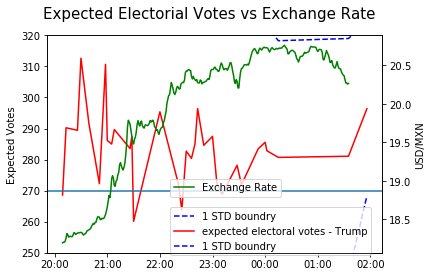

In [43]:
#%%
fig, ax1 = plt.subplots()
ax1.plot_date(pred.time, pred.low,'b--', label='1 STD boundry')
ax1.plot_date(pred.time, pred.ave,'r-', label='expected electoral votes - Trump')
ax1.plot_date(pred.time, pred.high,'b--', label='1 STD boundry')
plt.ylabel('Expected Votes')
#pylab.legend(loc='lower right')
plt.axhline(y=270)
ax1.legend(loc='center left', bbox_to_anchor=(0.35, 0.1))
ax1.set_ylim([250,320])

ax2 = ax1.twinx()
ax2.plot(fx['mean'],'g', label='Exchange Rate')

HMFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(HMFmt)
_ = plt.xticks(rotation=90)

plt.ylabel('USD/MXN')

#pylab.legend(loc='upper right')
ax2.legend(loc='center left', bbox_to_anchor=(0.35, 0.3))

fig.suptitle('Expected Electorial Votes vs Exchange Rate', fontsize=15)

plt.show()
fig.savefig('results.png')

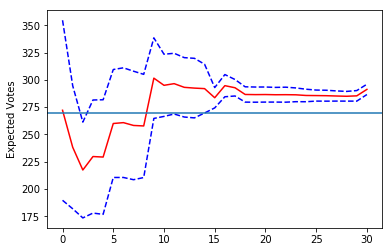

In [34]:
#plot after each update
fig, ax1 = plt.subplots()
ax1.plot(pred.low,'b--', label='95% confidence')
ax1.plot(pred.ave,'r-', label='expected electoral votes')
ax1.plot(pred.high,'b--', label='95% confidence')
plt.ylabel('Expected Votes')
yplt.axhline(y=270)
plt.show()

In [38]:
jointb

,State,poll_hc,poll_dt,poll_gj,result,time,trump,clinton,EV,intermediate,rprpc
0,nevada,47.1,45.9,5.8,0.0,2016-11-08 00:20,45.5,47.9,6,0,
1,vermont,60.2,32.8,5.2,0.0,2016-11-08 18:59,32.6,61.1,3,0,
2,kentucky,37.9,56.1,4.3,1.0,2016-11-08 18:59,62.5,32.7,8,0,
3,indiana,40.4,52.0,7.6,1.0,2016-11-08 18:59,57.2,37.9,11,0,
4,west virginia,33.3,59.8,5.1,1.0,2016-11-08 19:30,68.7,26.5,5,0,
5,oklahoma,33.2,59.2,7.6,1.0,2016-11-08 20:00,65.3,28.9,7,0,
6,ohio,45.8,47.7,5.3,0.0,2016-11-08 20:00,45.0,51.0,18,1,16
7,north carolina,48.2,47.5,4.3,0.0,2016-11-08 20:00,45.0,52.0,15,1,41
8,new jersey,53.5,42.0,3.1,0.0,2016-11-08 20:00,41.8,55.0,14,0,
9,massachusetts,58.0,34.6,5.8,0.0,2016-11-08 20:00,33.5,60.8,11,0,


In [50]:
X_dt, Y_dt

(    const  poll_dt
 6     1.0     47.7
 7     1.0     47.5
 13    1.0     47.5, 6     45.0
 7     45.0
 13    48.0
 Name: trump, dtype: float64)

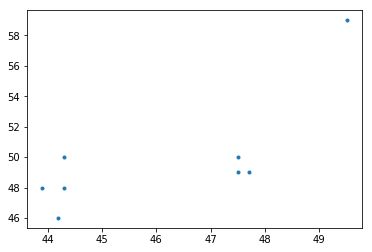

In [54]:
plt.plot(X_dt['poll_dt'].values, Y_dt.values, '.')
plt.show()